# Waveguidability (Wirth 2020)

Reproducing the figures of "Waveguidability of idealized midlatitude jets and the limitations of ray tracing theory" by [Wirth (2020)](https://doi.org/10.5194/wcd-1-111-2020).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import barotropic as bt

## Model configuration

Following the description in section 2, use a 2.5° resolution grid (corresponding to triangular trunction at wavenumber 72 in the spectral domain).

In [2]:
grid = bt.Grid(resolution=2.5)

The model is forced with a pseudo-orography in the shape of a Gaussian Mountain, centered at 30°E, 45°N in all experiments.
The standard deviation of the mountain is 10° in both latitude and longitude.
The amplitude of the forcing is 0.3, which is realized by a height of 3km and a scale height of 10km.
To produce a forcing independent of the actual flow, a constant reference wind profile of solid body rotation with a peak of 15 m/s zonal wind is used.

In [3]:
orography = bt.rhs.GaussianMountain(
    height=3000.,
    center=(30., 45.),
    stdev=(10., 10.),
    scale_height=10000.,
    wind=("sbr", 15.)
)

The initial state is zonally symmetric and consists of a Gaussian-shaped jet stream centered at 45°N, superimposed on a 15 m/s solid body rotation wind profile.

In addition to the pseudo-orographic forcing, a relaxation term constantly pulls the model back towards the initial state.
Hyperdiffusion is used to improve numerical stability.
The built-in diffusion of `BarotropicModel` is simpler compared to the diffusion term used in the paper.
Instead of `D·∇⁴(q - q₀)`, the model here uses `D·∇⁴q` where `q` is potential vorticity and `D = 1.0e-15 (m²/s)²`.
The expected effect is small, as hyperdiffusion is small in general and mainly exists for numerical stability reasons.

In [4]:
def get_setup(amplitude, width):
    """Initial state and configured model for a given jet scenario"""
    sbr = bt.init.solid_body_rotation(grid, amplitude=15)
    jet = bt.init.gaussian_jet(grid, center_lat=45, stdev_lat=width, amplitude=amplitude)
    bg = sbr.add_wind(jet)
    relaxation = bt.rhs.LinearRelaxation(1/(7*bt.DAY), bg.pv)
    model = bt.BarotropicModel(
        rhs=orography+relaxation,
        diffusion_order=2,
        diffusion_coeff=1.0e15
    )
    return bg, model

To reduce the required computation time for the parameter sweep, the model runs here are integrated only to 50 days instead of 100.
The integration time step is set to 20 min.
Snapshots of the model state are taken every 6 hours.

In [5]:
def run_setup(amplitude, width):
    """Run a given jet scenario simulation for 50 days"""
    bg, model = get_setup(amplitude, width)
    last, states = model.run(
        state_init=bg,
        dt=20*bt.MIN,
        tend=50*bt.DAY,
        save_every=6*bt.HOUR
    )
    return states

## Simulations

All required scenarios are simulated at once here and stored.
Start with the no jet scenario:

In [6]:
%time states_sbr = run_setup(amplitude=0, width=5)

CPU times: user 9.15 s, sys: 4.14 ms, total: 9.15 s
Wall time: 9.15 s


Computation times shown here are from a Haswell-era i5 laptop processor.

Now perform a parameter sweep for 10 non-zero jet amplitudes and 7 different jet widths.

In [7]:
def parameter_sweep(amplitudes, widths):
    """Simulate all combinations of the given jet strengths and amplitudes"""
    states = {}
    for amplitude in amplitudes:
        for width in widths:
            states[amplitude,width] = run_setup(amplitude, width)
    return states

In [8]:
jet_amplitudes = [2.5, 5, 7.5, 10, 15, 20, 25, 30, 35, 40]
jet_widths     = [5, 6.25, 7.5, 8.75, 10, 12.5, 15]

%time states = parameter_sweep(amplitudes=jet_amplitudes, widths=jet_widths)

CPU times: user 10min 42s, sys: 312 ms, total: 10min 42s
Wall time: 10min 42s


Add the no-jet scenario from above (for which jet-width is irrelevant as a parameter) to the collection.

In [9]:
jet_amplitudes.insert(0, 0)
for w in jet_widths:
    states[0,w] = states_sbr

## Figure 1

Hovmöller plot of the development of a barotropically unstable initial state (strong narrow jet).

First, define a function that compute the stationary part of a model run, which is the time average of a field between day 10 and the end of a model simulation.
This function will be used throughout this notebook.

In [10]:
def stationary(states, attr_or_func):
    """Stationary part of the solution"""
    if isinstance(attr_or_func, str):
        func = lambda state: getattr(state, attr_or_func)
    else:
        func = attr_or_func
    fields = [func(state) for state in states if state.time > 10*bt.DAY]
    return np.stack(fields).mean(axis=0)

Compute the stationary meridional wind for the strong narrow jet case.
Use it to calculate the transient meridional wind, averaged between 30°N and 60°N.

In [11]:
snj_stationary_v = stationary(states[40,5], "v")

def snj_transient_v(state):
    """The transient part of the meridional wind component (30-60°N)"""
    transient_v = state.v - snj_stationary_v
    imask = (grid.lat >= 30) & (grid.lat <= 60)
    return np.mean(np.ma.masked_array(transient_v, ~imask), axis=bt.MERIDIONAL)

Create a Hovmöller plot for the first 40 days of simulation.

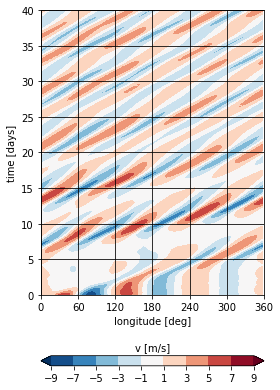

In [12]:
x, y, z = bt.plot.hovmoellerify(states[40,5], snj_transient_v)

fig, ax = plt.subplots(1, 1, figsize=(4, 6))
cf = ax.contourf(x, y/bt.DAY, z, cmap="RdBu_r", levels=[-9, -7, -5, -3, -1, 1, 3, 5, 7, 9], extend="both")
cb = plt.colorbar(cf, ax=ax, orientation="horizontal")
cb.ax.set_title("v [m/s]", fontsize=10)
ax.set_xlabel("longitude [deg]")
ax.set_xticks([0, 60, 120, 180, 240, 300, 360])
ax.set_ylabel("time [days]")
ax.set_ylim(0, 40)
ax.grid(color="black")
fig.tight_layout()

## Figure 2

Latitudinal profiles of the background zonal wind for the strong narrow jet case (blue solid line) and for the solid body rotation case (purple dashed line).

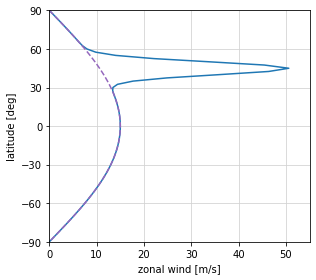

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(4.5, 4))
ax.plot(states[40,5][0].u.mean(axis=bt.ZONAL), grid.lats, color="tab:blue")
ax.plot(states[ 0,5][0].u.mean(axis=bt.ZONAL), grid.lats, color="tab:purple", linestyle="dashed")
ax.set_xlabel("zonal wind [m/s]")
ax.set_xlim([0, 55])
ax.set_ylabel("latitude [deg]")
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90])
ax.set_ylim([-90, 90])
ax.grid(color="lightgrey")
fig.tight_layout()

## Figure 3

Stationary part of the meridional wind for the solid body rotation and strong narrow jet cases. The orographic forcing is displayed as a yellow contour.

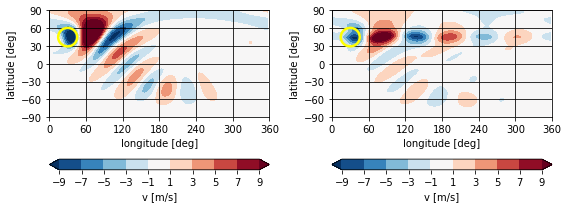

In [14]:
fig, ((ax1, ax2),
      (cx1, cx2)) = plt.subplots(2, 2, figsize=(8, 3),
                                 gridspec_kw=dict(height_ratios=(10, 1)))

cf1 = ax1.contourf(grid.lons, grid.lats, stationary(states[0,5], "v"),
                   cmap="RdBu_r", extend="both", levels=[-9, -7, -5, -3, -1, 1, 3, 5, 7, 9])
plt.colorbar(cf1, cax=cx1, orientation="horizontal")

cf2 = ax2.contourf(grid.lons, grid.lats, stationary(states[40,5], "v"),
                   cmap="RdBu_r", extend="both", levels=[-9, -7, -5, -3, -1, 1, 3, 5, 7, 9])
plt.colorbar(cf2, cax=cx2, orientation="horizontal")

for ax in (ax1, ax2):
    ax.contour(grid.lons, grid.lats, orography.orography(grid),
               levels=[900.], colors="yellow", linewidths=2.5)
    ax.grid(color="k")
    ax.set_xticks([0, 60, 120, 180, 240, 300, 360])
    ax.set_xlabel("longitude [deg]")
    ax.set_yticks([-90, -60, -30, 0, 30, 60, 90])
    ax.set_ylabel("latitude [deg]")
cx1.set_xlabel("v [m/s]")
cx2.set_xlabel("v [m/s]")
fig.tight_layout()

## Figure 4

Zonal wind profile (left), meridional gradient of PV (center) and stationary wavenumber (right) for the solid body rotation (top), weak narrow jet (middle) and strong narrow jet (bottom) background states.

In [15]:
def βm(state):
    """Meridional gradient of PV on the sphere"""
    return np.cos(grid.phis) * grid.ddphi(state.pv.mean(bt.ZONAL), order=2) / grid.rsphere

def fig4_βm_ks(state):
    """Compute all quantities needed for Figure 4"""
    betam = βm(state)
    ks = bt.diagnostic.stationary_wavenumber(state, order=2, kind="real")
    ki = np.where(ks < 0, ks, np.zeros_like(ks))
    um = state.u.mean(axis=bt.ZONAL)
    return um, betam, ks, ki

In [16]:
uβk = [
    fig4_βm_ks(states[ 0,5][0]), # no jet
    fig4_βm_ks(states[10,5][0]), # weak jet
    fig4_βm_ks(states[40,5][0])  # strong jet
]

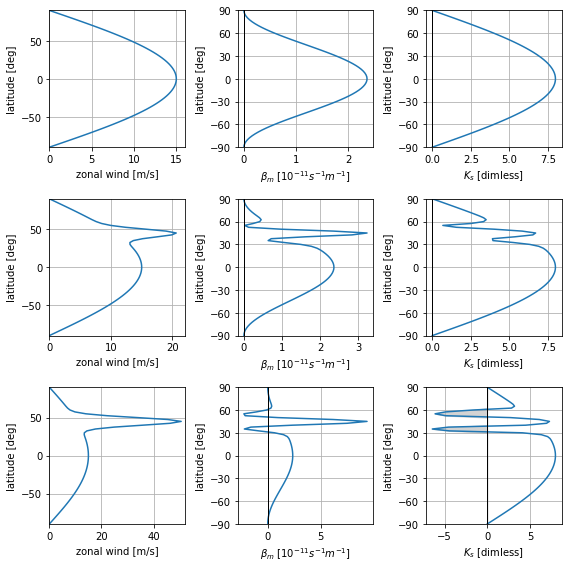

In [17]:
fig, axs = plt.subplots(3, 3, figsize=(8, 8))

for (ax1, ax2, ax3), (um, betam, ks, ki) in zip(axs, uβk):
    ax1.plot(um, grid.lats)
    ax2.plot(betam * 1.0e11, grid.lats)
    ax3.plot(ks, grid.lats)
    ax3.fill_betweenx(grid.lats, ki, color="lightgrey")

# Column 1: zonal wind
axs[0][0].set_xlim([0, 16])
axs[1][0].set_xlim([0, 22])
axs[2][0].set_xlim([0, 52])
for ax in (axs[0][0], axs[1][0], axs[2][0]):
    ax.set_xlabel("zonal wind [m/s]")
# Column 2: beta_m
for ax in (axs[0][1], axs[1][1], axs[2][1]):
    ax.axvline(0, color="black", linewidth=1)
    ax.set_xlabel("$\\beta_m$ [$10^{-11}s^{-1}m^{-1}$]")
    ax.set_yticks([-90, -60, -30, 0, 30, 60, 90])
# Column 3: Ks
for ax in (axs[0][2], axs[1][2], axs[2][2]):
    ax.axvline(0, color="black", linewidth=1)
    ax.set_xlabel("$K_s$ [dimless]")
    ax.set_yticks([-90, -60, -30, 0, 30, 60, 90])
# All
for ax in axs.flatten():
    ax.set_ylabel("latitude [deg]")
    ax.set_ylim([-90, 90])
    ax.grid()    
fig.tight_layout()

## Figure 5

Probability Density Functions from which waveguidability metric is derived for simulations with solid body rotation and strong narrow jet background profiles.

In [18]:
def enstrophy_pdf(pv, lon_left=180, lon_right=270):
    """P(ϕ), the enstrophy-based "waviness" PDF"""
    pv_mean = pv.mean(axis=bt.ZONAL, keepdims=True)
    imask = (lon_left <= grid.lon) & (grid.lon <= lon_right)
    eddy_ens = np.ma.masked_array((pv - pv_mean)**2, ~imask)
    pdf = np.cos(grid.phis) * np.sum(eddy_ens, axis=bt.ZONAL)
    # Return normalized pdf
    return pdf / np.sum(pdf) / np.pi * grid.nlat

def waveguidability_from_pdf(pdf, lat_low=30, lat_high=60):
    """Compute waveguidabilty metric from enstrophy-pdf in %"""
    imask = (lat_low <= grid.lats) & (grid.lats <= lat_high)
    pdf_region = np.ma.masked_array(pdf, ~imask)
    return np.sum(pdf_region) / np.sum(pdf) * 100

def waveguidability(states):
    """Waveguidability metric for a simulation"""
    return waveguidability_from_pdf(enstrophy_pdf(stationary(states, "pv")))

Compute and plot PDF and waveguidability metric for the two chosen cases.

In [19]:
pdf_sbr = enstrophy_pdf(stationary(states[ 0,5], "pv"))
pdf_jet = enstrophy_pdf(stationary(states[40,5], "pv"))

wg_sbr = waveguidability_from_pdf(pdf_sbr)
wg_jet = waveguidability_from_pdf(pdf_jet)

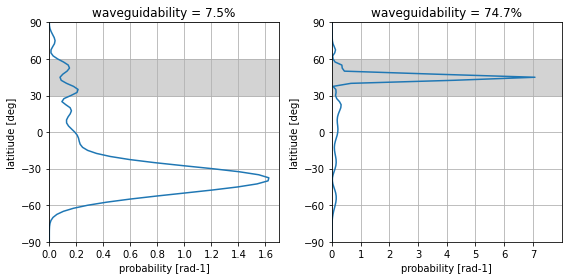

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

ax1.set_title("waveguidability = {:.1f}%".format(wg_sbr))
ax1.plot(pdf_sbr, grid.lats)
ax1.set_xlim([0, 1.7])
ax1.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6])
ax1.fill_betweenx([30, 60], 0, 1.7, color="lightgrey")

ax2.set_title("waveguidability = {:.1f}%".format(wg_jet))
ax2.plot(pdf_jet, grid.lats)
ax2.set_xlim([0, 8])
ax2.set_xticks([0, 1, 2, 3, 4, 5, 6, 7])
ax2.fill_betweenx([30, 60], 0, 8, color="lightgrey")

for ax in (ax1, ax2):
    ax.set_ylabel("latitiude [deg]")
    ax.set_yticks([-90, -60, -30, 0, 30, 60, 90])
    ax.set_ylim([-90, 90])
    ax.set_xlabel("probability [rad-1]")
    ax.grid()
fig.tight_layout()

Compared to the values from Wirth (2020), the differences are only small:
7.5% vs 7.5% for the solid body rotation case and 74.7% vs 75.4% in the strong narrow jet case.


## Figure 6

Dependence of waveguidability on jet strength and jet width.

In [21]:
wg_amplitude_vary = [waveguidability(states[ a,5]) for a in jet_amplitudes]
wg_width_vary     = [waveguidability(states[40,w]) for w in jet_widths]

The WKB-based waveguidability measures from the paper are recreated based on the built-in waveguide extraction of `barotropic`.
A waveguide is considered to be present if its northern edge is somewhere in the range of 80°N and 40°N and its southern edge somewhere in the range 50°N and 10°N.
This excludes the solid body rotation from being recognized as a relevant waveguide.

The fractional waveguidability derived from WKB-theory is defined as in the paper as "the fraction of the number of wavenumbers with two turning latitudes divided by the number of all wavenumbers allowing wavelike behavior within the jet region".

In [22]:
def has_waveguide(state, wavenumber):
    """Does the state have a NH-midlatitude waveguide at the given wavenumber?"""
    return any(80 > n > 40 and 50 > s > 10 for n, s in state.extract_waveguides(wavenumber))

def waveguidability_wkb_frac(state, accuracy=120):
    """Fraction of trapped wavenumbers of all possible wavenumbers (below stationary)"""
    ks = bt.diagnostic.stationary_wavenumber(state, kind="real")
    kmax = 0
    kmin = 10
    for k in np.linspace(0, max(ks), accuracy):
        if has_waveguide(state, k):
            kmax = max(kmax, k)
            kmin = min(kmin, k)
    return 0 if kmin >= kmax else (kmax - kmin) / kmax

Use wavenumber 4 for the plot with constant jet width and wavenumber 3 for the plot with constant jet strength (as seen in Figure 7, the dominant wavenumber for strong jets is 3).

In [23]:
a100 = np.linspace(0, 40, 50)
wg_wkb_amplitude_vary  = [100 if has_waveguide(get_setup(a, 5)[0], 4) else 0 for a in a100]
wg_wkbf_amplitude_vary = [100 * waveguidability_wkb_frac(get_setup(a, 5)[0]) for a in a100]

w100 = np.linspace(5, 15, 50)
wg_wkb_width_vary  = [100 if has_waveguide(get_setup(40, w)[0], 3) else 0 for w in w100]
wg_wkbf_width_vary = [100 * waveguidability_wkb_frac(get_setup(40, w)[0]) for w in w100]

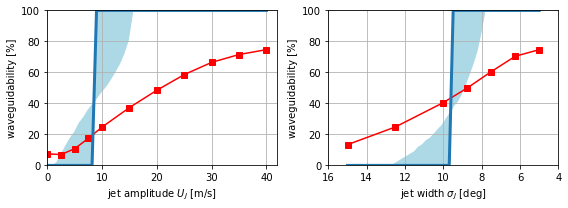

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

ax1.plot(jet_amplitudes, wg_amplitude_vary, color="red", marker="s")
ax1.plot(a100, wg_wkb_amplitude_vary, color="tab:blue", linewidth=3)
ax1.fill_between(a100, wg_wkb_amplitude_vary, wg_wkbf_amplitude_vary, color="lightblue")
ax1.set_xlim(0, 42)
ax1.set_xlabel("jet amplitude $U_J$ [m/s]")

ax2.plot(jet_widths, wg_width_vary, color="red", marker="s")
ax2.plot(w100, wg_wkb_width_vary, color="tab:blue", linewidth=3)
ax2.fill_between(w100, wg_wkb_width_vary, wg_wkbf_width_vary, color="lightblue")
ax2.set_xlim(16, 4)
ax2.set_xlabel("jet width $\sigma_J$ [deg]")

for ax in (ax1, ax2):
    ax.set_ylim(0, 100)
    ax.set_ylabel("waveguidability [%]")
    ax.grid()
fig.tight_layout()

The red curves for the paper's waveguidability measure are very close to the ones seen in the paper.
The blue curves for the WKB-based waveguidability switch from 0% to 100% at smaller jet strengths and wider jet widths.
This as well as the more curved shape of the blue areas is likely related to different resolutions of source data used to create the plots.


## Figure 7

Fourier power spectra of the stationary part of the meridional wind in the northern hemisphere midlatitudes for the solid body rotation, weak narrow jet and strong narrow jet cases.

In [25]:
def mean_v_fourier(states):
    """Normalized Fourier power spectrum of stationary v in 30-60°N"""
    imask = ((30 <= grid.lat) & (grid.lat <= 60))
    mean_v = np.ma.masked_array(stationary(states, "v"), ~imask)
    mean_v = mean_v.mean(axis=bt.MERIDIONAL)
    return np.abs( np.fft.rfft(mean_v) / grid.nlon)**2

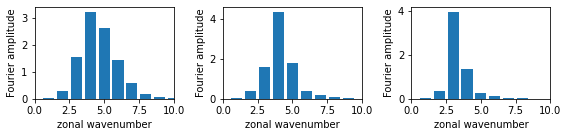

In [26]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 2))

ax1.bar(np.arange(grid.nlat), mean_v_fourier(states[ 0,5]))
ax2.bar(np.arange(grid.nlat), mean_v_fourier(states[10,5]))
ax3.bar(np.arange(grid.nlat), mean_v_fourier(states[40,5]))

for ax in (ax1, ax2, ax3):
    ax.set_xlim(0, 10)
    ax.set_xlabel("zonal wavenumber")
    ax.set_ylabel("Fourier amplitude")
fig.tight_layout()

## Figure 8

Figure 6, but with meridional PV gradient at 45°N instead of WKB-based waveguidability.

In [27]:
def βm45_scaled(state):
    """Meridional PV gradient at 45°N, scaled for Figure 8"""
    return np.sum(np.where(grid.lats == 45, βm(state), 0)) * 8.5e11

In [28]:
βm_amplitude_vary = [βm45_scaled(states[ a,5][0]) for a in jet_amplitudes]
βm_width_vary     = [βm45_scaled(states[40,w][0]) for w in jet_widths]

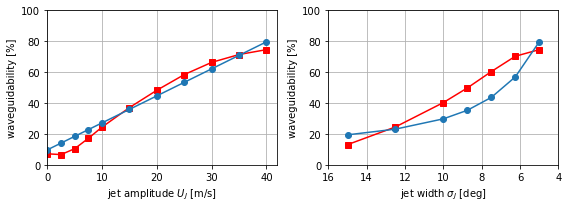

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

ax1.plot(jet_amplitudes, wg_amplitude_vary, color="red", marker="s")
ax1.plot(jet_amplitudes, βm_amplitude_vary, color="tab:blue", marker="o")
ax1.set_xlim(0, 42)
ax1.set_xlabel("jet amplitude $U_J$ [m/s]")

ax2.plot(jet_widths, wg_width_vary, color="red", marker="s")
ax2.plot(jet_widths, βm_width_vary, color="tab:blue", marker="o")
ax2.set_xlim(16, 4)
ax2.set_xlabel("jet width $\sigma_J$ [deg]")

for ax in (ax1, ax2):
    ax.set_ylim(0, 100)
    ax.set_ylabel("waveguidability [%]")
    ax.grid()
fig.tight_layout()

## Figure 9

Parameter sweep.

In [30]:
wg_all = [[waveguidability(states[a,w]) for a in jet_amplitudes] for w in jet_widths]
βm_all = [[βm45_scaled(states[a,w][0])  for a in jet_amplitudes] for w in jet_widths]

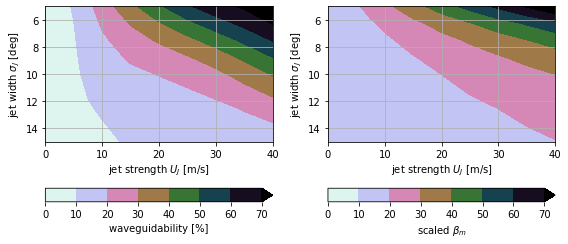

In [31]:
fig, ((ax1, ax2),
      (cx1, cx2)) = plt.subplots(2, 2, figsize=(8, 3.5),
                                 gridspec_kw=dict(height_ratios=(10, 1)))

cf1 = ax1.contourf(jet_amplitudes, jet_widths, wg_all, cmap="cubehelix_r", extend="max",
             levels=[0, 10, 20, 30, 40, 50, 60, 70])
plt.colorbar(cf1, cax=cx1, orientation="horizontal").set_label("waveguidability [%]")

cf2 = ax2.contourf(jet_amplitudes, jet_widths, βm_all, cmap="cubehelix_r", extend="max",
             levels=[0, 10, 20, 30, 40, 50, 60, 70])
plt.colorbar(cf2, cax=cx2, orientation="horizontal").set_label("scaled $β_m$")

for ax in (ax1, ax2):
    ax.set_ylim([15, 5])
    ax.set_ylabel("jet width $\sigma_J$ [deg]")
    ax.set_xlim([0, 40])
    ax.set_xlabel("jet strength $U_J$ [m/s]")
    ax.grid()
fig.tight_layout()

The 10% contour in the left plot differs somewhat from the one in the paper for wide jets but otherwise agreement is good.


## Figure 10

Linearity check.
Rerun the 10 m/s amplitude, 5° width scenario with 1000-times smaller forcing.
In the paper, the forcing is 10000-times smaller.
However, this results in somewhat noisy fields here and the factor 1000 is used instead (this should still give a good indication of linearity).

In [32]:
orography_small = bt.rhs.GaussianMountain(
    height=3.,
    center=(30., 45.),
    stdev=(10., 10.),
    scale_height=10000.,
    wind=("sbr", 15.)
)

sbr = bt.init.solid_body_rotation(grid, amplitude=15)
jet = bt.init.gaussian_jet(grid, center_lat=45, amplitude=10, stdev_lat=5)
bg = sbr.add_wind(jet)
relaxation = bt.rhs.LinearRelaxation(1/(7*bt.DAY), bg.pv)

model_small = bt.BarotropicModel(
    rhs=orography_small+relaxation,
    diffusion_order=2,
    diffusion_coeff=1.0e15
)
_, states_small = model_small.run(
    state_init=bg,
    dt=20*bt.MIN,
    tend=50*bt.DAY,
    save_every=6*bt.HOUR
)

In [33]:
psi_stationary       = stationary(states[10,5], "streamfunction")
psi_stationary_small = stationary(states_small, "streamfunction")

psi_perturb       = psi_stationary - np.mean(psi_stationary, axis=bt.ZONAL, keepdims=True)
psi_perturb_small = psi_stationary_small - np.mean(psi_stationary_small, axis=bt.ZONAL, keepdims=True)

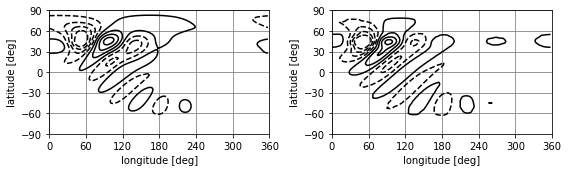

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 2.5))

levels = [-1.4e7, -1.0e7, -0.6e7, -0.2e7, 0.2e7, 0.6e7, 1.0e7, 1.4e7]

ax1.contour(grid.lons, grid.lats,         psi_perturb,       levels=levels, colors="black")
ax2.contour(grid.lons, grid.lats, 1.0e3 * psi_perturb_small, levels=levels, colors="black")

for ax in (ax1, ax2):
    ax.grid(color="grey")
    ax.set_xticks([0, 60, 120, 180, 240, 300, 360])
    ax.set_xlabel("longitude [deg]")
    ax.set_yticks([-90, -60, -30, 0, 30, 60, 90])
    ax.set_ylabel("latitude [deg]")
fig.tight_layout()